In [2]:
# from imblearn.over_sampling import MultiOutputSMOTE
from imblearn.over_sampling import SMOTE
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('dataset/UnderstandingBusiness/UW_Understanding_Business_LOT.csv')

/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_41459/1723780546.py:1: DtypeWarning: Columns (4,10,11,12,13,14,16,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset/UnderstandingBusiness/UW_Understanding_Business_LOT.csv')


In [4]:
df.shape

(1323762, 34)

In [5]:
df.head()

,source_type,TIMESTAMP,COOKIE_ID,VISIT_NUMBER,PAGE,PAGE_VIEWS,MARKETING_CHANNEL,PLATFORM_TYPE,OPERATING_SYSTEMS,MARKET_LANGUAGE,CUSTOMER_LOYALTY,DEPARTURE_DATE,ARRIVAL_DATE,ORIGIN_AND_DESTINATION_PORTS,RANGE,STAY_LENGTH,FLIGHT_TYPE,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,CLASS_TYPE,FARE_FAMILY,FLOW_TYPE,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,TRANSACTION,2023-08-15 18:10:18,90160409479417649411999102181002937619,563,NaN,NaN,SEO,Mobile App,ios 17.3.1,PL_PL,loyal,2023-09-13,2022-11-13,WAW-AMS,Short Haul,1.0,Round-Trip,2.0,28.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,TRANSACTION,2023-08-07 08:07:50,83506423751136985820103526870163297871,72,NaN,NaN,Direct,Mobile App,ios 18.0,PL_PL,return,2023-08-09,2022-11-09,GDN-RZE,Domestic,1.0,Round-Trip,4.0,1.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,TRANSACTION,2023-07-09 12:27:11,78236612428921115877508527232487027464,95,NaN,NaN,Direct,Mobile App,ios 17.6.1,PL_PL,loyal,2023-07-15,2022-11-20,PRG-WAW,Short Haul,7.0,Round-Trip,2.0,5.0,1.0,0.0,0.0,0.0,Economy,Standard,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,TRANSACTION,2023-07-20 07:15:18,86513654906858836814951255651058285578,296,NaN,NaN,Direct,Mobile App,ios 17.6.1,PL_PL,loyal,2023-07-25,2022-11-25,WRO-WAW,Domestic,2.0,Round-Trip,2.0,4.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TRANSACTION,2023-08-22 05:27:37,07263717780177747617979091720349832062,127,NaN,NaN,Direct,Mobile App,ios 18.0,PL_PL,loyal,2023-08-29,NaN,CPH-RZE,Short Haul,NaN,One-Way,2.0,6.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
df['PAGE'] = df['PAGE'].fillna(0)
df['PAGE_VIEWS'] = df['PAGE_VIEWS'].fillna(0)
df['STAY_LENGTH'] = df['STAY_LENGTH'].fillna(0)
df['OPERATING_SYSTEMS'] = df['OPERATING_SYSTEMS'].apply(lambda x: x.split(' ')[0])

In [7]:
df.head()

,source_type,TIMESTAMP,COOKIE_ID,VISIT_NUMBER,PAGE,PAGE_VIEWS,MARKETING_CHANNEL,PLATFORM_TYPE,OPERATING_SYSTEMS,MARKET_LANGUAGE,CUSTOMER_LOYALTY,DEPARTURE_DATE,ARRIVAL_DATE,ORIGIN_AND_DESTINATION_PORTS,RANGE,STAY_LENGTH,FLIGHT_TYPE,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,CLASS_TYPE,FARE_FAMILY,FLOW_TYPE,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,TRANSACTION,2023-08-15 18:10:18,90160409479417649411999102181002937619,563,0,0.0,SEO,Mobile App,ios,PL_PL,loyal,2023-09-13,2022-11-13,WAW-AMS,Short Haul,1.0,Round-Trip,2.0,28.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,TRANSACTION,2023-08-07 08:07:50,83506423751136985820103526870163297871,72,0,0.0,Direct,Mobile App,ios,PL_PL,return,2023-08-09,2022-11-09,GDN-RZE,Domestic,1.0,Round-Trip,4.0,1.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,TRANSACTION,2023-07-09 12:27:11,78236612428921115877508527232487027464,95,0,0.0,Direct,Mobile App,ios,PL_PL,loyal,2023-07-15,2022-11-20,PRG-WAW,Short Haul,7.0,Round-Trip,2.0,5.0,1.0,0.0,0.0,0.0,Economy,Standard,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,TRANSACTION,2023-07-20 07:15:18,86513654906858836814951255651058285578,296,0,0.0,Direct,Mobile App,ios,PL_PL,loyal,2023-07-25,2022-11-25,WRO-WAW,Domestic,2.0,Round-Trip,2.0,4.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TRANSACTION,2023-08-22 05:27:37,07263717780177747617979091720349832062,127,0,0.0,Direct,Mobile App,ios,PL_PL,loyal,2023-08-29,NaN,CPH-RZE,Short Haul,0.0,One-Way,2.0,6.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323762 entries, 0 to 1323761
Data columns (total 34 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   source_type                   1323762 non-null  object 
 1   TIMESTAMP                     1182159 non-null  object 
 2   COOKIE_ID                     1323762 non-null  object 
 3   VISIT_NUMBER                  1323762 non-null  int64  
 4   PAGE                          1323762 non-null  object 
 5   PAGE_VIEWS                    1323762 non-null  float64
 6   MARKETING_CHANNEL             1323762 non-null  object 
 7   PLATFORM_TYPE                 1323762 non-null  object 
 8   OPERATING_SYSTEMS             1323762 non-null  object 
 9   MARKET_LANGUAGE               1323490 non-null  object 
 10  CUSTOMER_LOYALTY              35879 non-null    object 
 11  DEPARTURE_DATE                35590 non-null    object 
 12  ARRIVAL_DATE                

In [9]:
categorical_cols = [
    'source_type', 'MARKETING_CHANNEL', 'PLATFORM_TYPE', 'ORIGIN_AND_DESTINATION_PORTS',
    'OPERATING_SYSTEMS', 'CUSTOMER_LOYALTY', 'FLIGHT_TYPE',
    'CLASS_TYPE', 'FARE_FAMILY', 'RANGE', 'FLOW_TYPE'
]

numerical_cols = [
    'VISIT_NUMBER', 'PAGE', 'PAGE_VIEWS',
    'STAY_LENGTH', 'NUMBER_OF_SEGMENTS', 'DAYS_TO_DEPARTURE',
    'ADULTS', 'TEENS', 'CHILDS',
    'INFANTS', 'BOOKING_CONFIRMATION', 'BOOKING_CHANGE_CONFIRMATION'
]
# numerical_cols = ['DAYS_TO_DEPARTURE', 'NUMBER_OF_SEGMENTS']
# numerical_cols = [col for col in df.columns if col not in categorical_cols and df[col].dtype in ['int64', 'float64']]

exclude_cols = ['COOKIE_ID', 'TIMESTAMP', 'MARKET_LANGUAGE', 'DEPARTURE_DATE', 'ARRIVAL_DATE']

ancillaries = [
    'PAID_SEATS', 'ONBOARD_MEALS', 
    'EXTRA_BAGGAGE', 'BUSINESS_LOUNGE', 
    'SPECIAL_EQUIPMENT', 'FAST_TRACK'
]

In [10]:
numerical_cols = [col for col in df.columns if col not in categorical_cols+ancillaries and pd.api.types.is_numeric_dtype(df[col])]

In [11]:
numerical_cols

['VISIT_NUMBER',
 'PAGE_VIEWS',
 'STAY_LENGTH',
 'NUMBER_OF_SEGMENTS',
 'DAYS_TO_DEPARTURE',
 'ADULTS',
 'TEENS',
 'CHILDS',
 'INFANTS',
 'BOOKING_CONFIRMATION',
 'BOOKING_CHANGE_CONFIRMATION']

In [12]:
# df.loc[:, ~df.columns.isin(exclude_cols)] = df.loc[:, ~df.columns.isin(exclude_cols)].fillna(0)
df = df.loc[:, ~df.columns.isin(exclude_cols)]

In [13]:
df.source_type.unique()

array(['TRANSACTION', 'ACTIVITY'], dtype=object)

In [14]:
df.head(20).to_csv('Sample_UW_Understanding_Business_LOT_head.csv', index=False)

In [15]:
# Check basic statistics of the dataset
eda_summary = df.describe(include='all')
eda_summary.T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
source_type,1323762,2,ACTIVITY,1287883,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VISIT_NUMBER,1323762.0,NaN,NaN,NaN,97.58109,187.40431,1.0,5.0,24.0,100.0,1794.0
PAGE,1323762,13081,www.lot.com/pl/pl/book/availability/departure,104049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAGE_VIEWS,1323762.0,NaN,NaN,NaN,0.977701,0.211543,0.0,1.0,1.0,1.0,25.0
MARKETING_CHANNEL,1323762,9,Direct,399506,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLATFORM_TYPE,1323762,3,Regular Web,845914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OPERATING_SYSTEMS,1323762,7,windows,651813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUSTOMER_LOYALTY,35879,3,loyal,17728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN_AND_DESTINATION_PORTS,35599,2625,WAW-LHR,640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RANGE,35591,3,Short Haul,25354,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
na_values = df.isna().sum()
na_values[na_values > 0].sort_values(ascending=False)

NUMBER_OF_SEGMENTS              1288173
DAYS_TO_DEPARTURE               1288172
RANGE                           1288171
FLIGHT_TYPE                     1288171
ORIGIN_AND_DESTINATION_PORTS    1288163
CUSTOMER_LOYALTY                1287883
PAID_SEATS                      1287883
BOOKING_CONFIRMATION            1287883
FAST_TRACK                      1287883
SPECIAL_EQUIPMENT               1287883
BUSINESS_LOUNGE                 1287883
EXTRA_BAGGAGE                   1287883
ONBOARD_MEALS                   1287883
CLASS_TYPE                      1287883
FLOW_TYPE                       1287883
FARE_FAMILY                     1287883
INFANTS                         1287883
CHILDS                          1287883
TEENS                           1287883
ADULTS                          1287883
BOOKING_CHANGE_CONFIRMATION     1287883
dtype: int64

In [17]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

NUMBER_OF_SEGMENTS              1288173
DAYS_TO_DEPARTURE               1288172
RANGE                           1288171
FLIGHT_TYPE                     1288171
ORIGIN_AND_DESTINATION_PORTS    1288163
CUSTOMER_LOYALTY                1287883
PAID_SEATS                      1287883
BOOKING_CONFIRMATION            1287883
FAST_TRACK                      1287883
SPECIAL_EQUIPMENT               1287883
BUSINESS_LOUNGE                 1287883
EXTRA_BAGGAGE                   1287883
ONBOARD_MEALS                   1287883
CLASS_TYPE                      1287883
FLOW_TYPE                       1287883
FARE_FAMILY                     1287883
INFANTS                         1287883
CHILDS                          1287883
TEENS                           1287883
ADULTS                          1287883
BOOKING_CHANGE_CONFIRMATION     1287883
dtype: int64

In [18]:
df.MARKETING_CHANNEL.unique()

array(['SEO', 'Direct', 'Social Media', 'SEM', 'Email', 'Remarketing',
       'Programmatic', 'Display', 'QR Code'], dtype=object)

In [19]:
for dtype in df.dtypes:
    if dtype == 'object':
        print(df.select_dtypes(include=[dtype]).nunique())

source_type                         2
PAGE                            13081
MARKETING_CHANNEL                   9
PLATFORM_TYPE                       3
OPERATING_SYSTEMS                   7
CUSTOMER_LOYALTY                    3
ORIGIN_AND_DESTINATION_PORTS     2625
RANGE                               3
FLIGHT_TYPE                         3
CLASS_TYPE                          3
FARE_FAMILY                         3
FLOW_TYPE                           2
dtype: int64
source_type                         2
PAGE                            13081
MARKETING_CHANNEL                   9
PLATFORM_TYPE                       3
OPERATING_SYSTEMS                   7
CUSTOMER_LOYALTY                    3
ORIGIN_AND_DESTINATION_PORTS     2625
RANGE                               3
FLIGHT_TYPE                         3
CLASS_TYPE                          3
FARE_FAMILY                         3
FLOW_TYPE                           2
dtype: int64
source_type                         2
PAGE                    

In [20]:
# Check for class imbalance in the target columns
ancillary_class_distribution = df[ancillaries].mean()
ancillary_class_distribution.sort_values(ascending=False)

PAID_SEATS           28.478985
EXTRA_BAGGAGE        13.158268
SPECIAL_EQUIPMENT     0.816341
FAST_TRACK            0.626396
ONBOARD_MEALS         0.581447
BUSINESS_LOUNGE       0.229430
dtype: float64

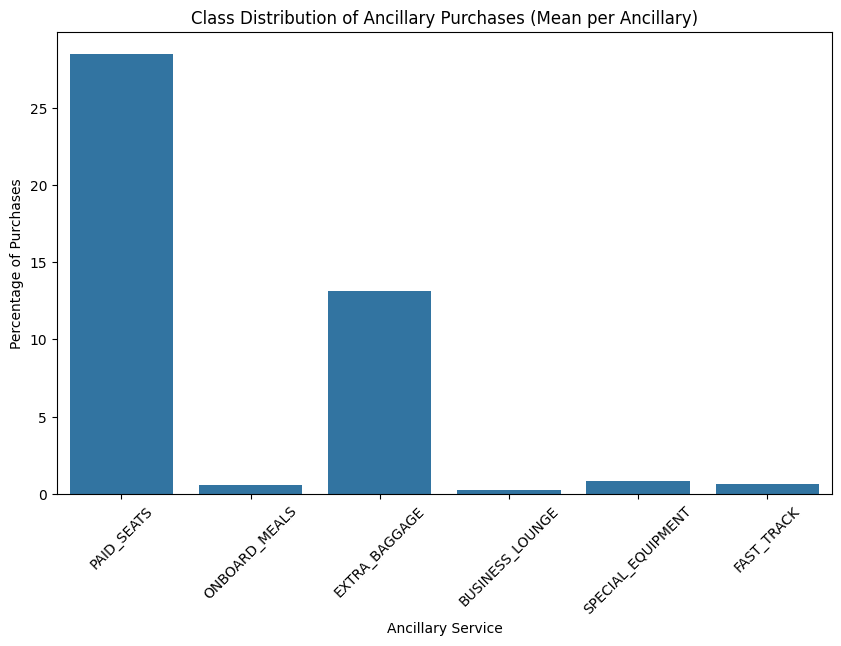

In [21]:
# Visualize the class distribution of target variables
plt.figure(figsize=(10, 6))
sns.barplot(x=ancillary_class_distribution.index, y=ancillary_class_distribution.values)
plt.title('Class Distribution of Ancillary Purchases (Mean per Ancillary)')
plt.ylabel('Percentage of Purchases')
plt.xlabel('Ancillary Service')
plt.xticks(rotation=45)
plt.show()

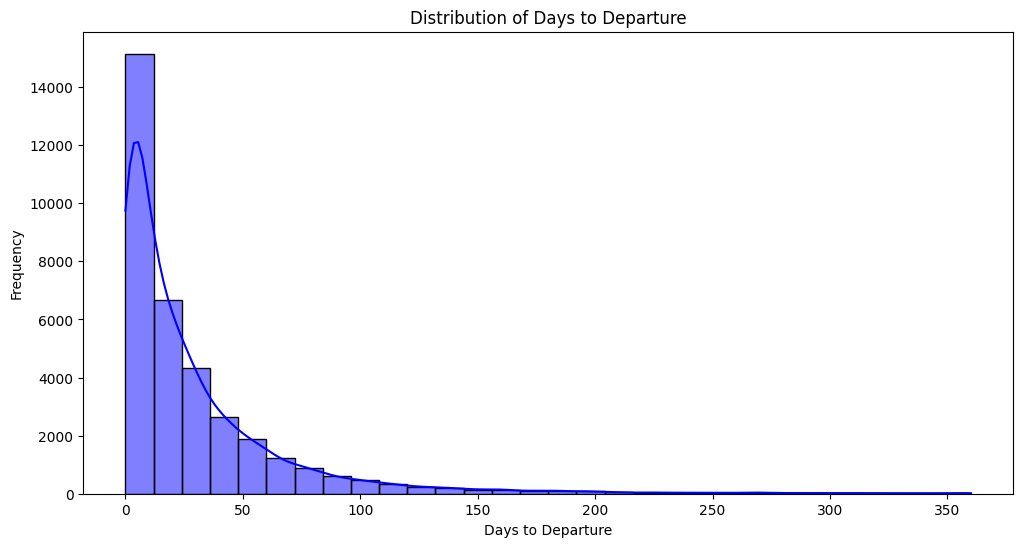

In [22]:
# Visualize the distribution of some important features
plt.figure(figsize=(12, 6))
sns.histplot(df['DAYS_TO_DEPARTURE'], kde=True, color='blue', bins=30)
plt.title('Distribution of Days to Departure')
plt.xlabel('Days to Departure')
plt.ylabel('Frequency')
plt.show()


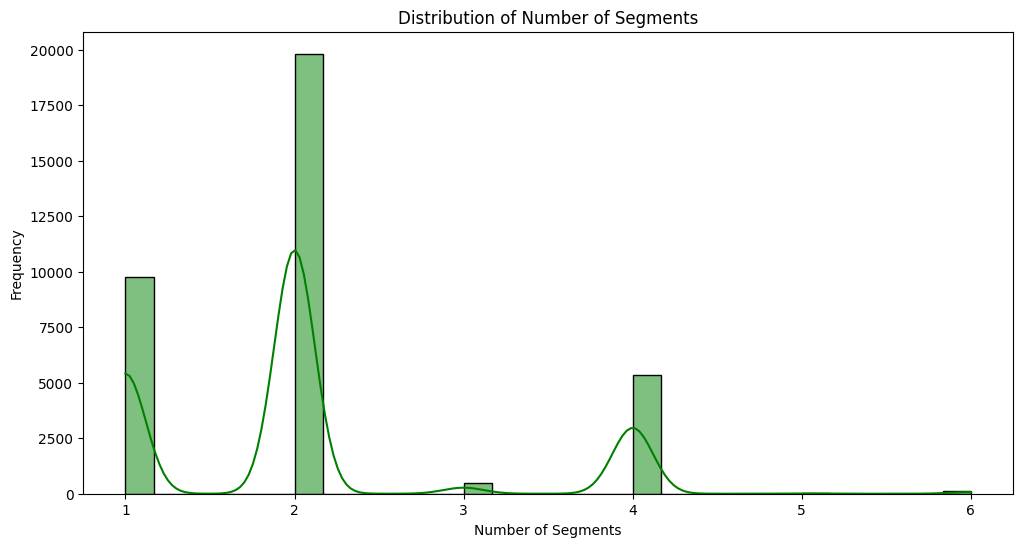

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(df['NUMBER_OF_SEGMENTS'], kde=True, color='green', bins=30)
plt.title('Distribution of Number of Segments')
plt.xlabel('Number of Segments')
plt.ylabel('Frequency')
plt.show()

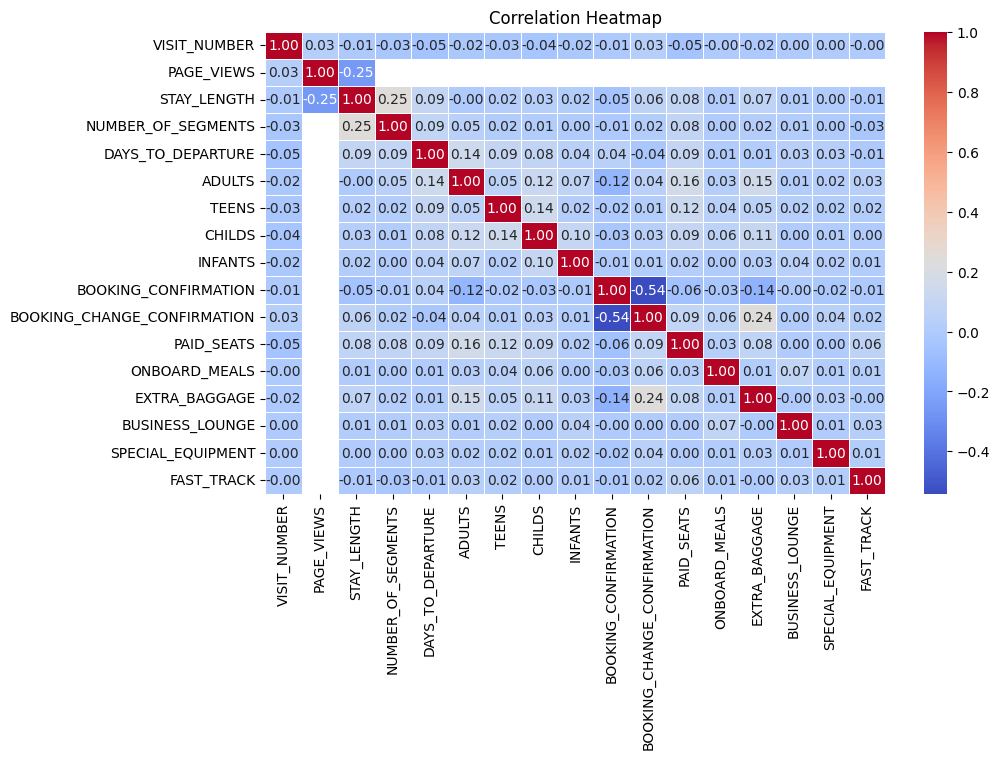

In [24]:
# Visualizing correlations with heatmap
corr = df[numerical_cols + ancillaries].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

## Handling Missing Values

In [26]:
for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

In [27]:
df.STAY_LENGTH.unique()

array([  1.,   7.,   2.,   0.,   3.,   5.,   8.,   4.,   6.,  22.,  11.,
        17.,   9.,  14.,  13.,  10.,  18.,  47.,  15.,  23.,  21.,  16.,
        39.,  27.,  12.,  31.,  28.,  25.,  80.,  48., 100.,  19.,  70.,
        30.,  29.,  35.,  26.,  37.,  24., 111.,  34.,  33.,  53., 147.,
        66.,  32.,  20.,  36., 163.,  42.,  99.,  38.,  62.,  41.,  88.,
       139., 141., 193.,  67.,  71., 128.,  60.,  52.,  78.,  40.,  84.,
       103.,  69.,  68.,  49., 126.,  54.,  45., 151.,  56.,  59.,  87.,
        81.,  76.,  73.,  44., 106., 108.,  63., 175., 129.,  77., 179.,
        95., 143., 114., 104., 154.,  72., 277., 201.,  50.,  86.,  93.,
        55., 173., 156.,  43., 259., 113., 166., 284.,  90.,  91.,  83.,
        57.,  79.,  96., 314., 135., 218.,  65.,  89., 162., 188., 186.,
       301., 280.,  46., 119.,  98.,  51.,  58., 167.,  82., 142.,  74.,
       248., 171., 190.,  64., 117.,  61., 182., 204., 101., 109., 196.,
       136.,  85., 181., 124.,  92., 105., 249., 11

In [28]:
for col in numerical_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

In [29]:
cleaned_df = df.dropna(subset=ancillaries)

In [30]:
cleaned_df.shape

(35879, 29)

In [31]:
cleaned_df.head()

,source_type,VISIT_NUMBER,PAGE,PAGE_VIEWS,MARKETING_CHANNEL,PLATFORM_TYPE,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,ORIGIN_AND_DESTINATION_PORTS,RANGE,STAY_LENGTH,FLIGHT_TYPE,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,CLASS_TYPE,FARE_FAMILY,FLOW_TYPE,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,TRANSACTION,563,0,0.0,SEO,Mobile App,ios,loyal,WAW-AMS,Short Haul,1.0,Round-Trip,2.0,28.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,TRANSACTION,72,0,0.0,Direct,Mobile App,ios,return,GDN-RZE,Domestic,1.0,Round-Trip,4.0,1.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,TRANSACTION,95,0,0.0,Direct,Mobile App,ios,loyal,PRG-WAW,Short Haul,7.0,Round-Trip,2.0,5.0,1.0,0.0,0.0,0.0,Economy,Standard,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,TRANSACTION,296,0,0.0,Direct,Mobile App,ios,loyal,WRO-WAW,Domestic,2.0,Round-Trip,2.0,4.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TRANSACTION,127,0,0.0,Direct,Mobile App,ios,loyal,CPH-RZE,Short Haul,0.0,One-Way,2.0,6.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Label encode categorical columns

In [32]:
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col, le in label_encoders.items():
    cleaned_df[col] = le.fit_transform(cleaned_df[col])

/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_41459/315653069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[col] = le.fit_transform(cleaned_df[col])
/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_41459/315653069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[col] = le.fit_transform(cleaned_df[col])
/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_41459/315653069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [33]:
cleaned_df.head()

,source_type,VISIT_NUMBER,PAGE,PAGE_VIEWS,MARKETING_CHANNEL,PLATFORM_TYPE,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,ORIGIN_AND_DESTINATION_PORTS,RANGE,STAY_LENGTH,FLIGHT_TYPE,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,CLASS_TYPE,FARE_FAMILY,FLOW_TYPE,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,0,563,0,0.0,6,0,2,0,2327,2,1.0,2,2.0,28.0,1.0,0.0,0.0,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,72,0,0.0,0,0,2,2,689,0,1.0,2,4.0,1.0,1.0,0.0,0.0,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,95,0,0.0,0,0,2,0,1660,2,7.0,2,2.0,5.0,1.0,0.0,0.0,0.0,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,296,0,0.0,0,0,2,0,2520,0,2.0,2,2.0,4.0,1.0,0.0,0.0,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,127,0,0.0,0,0,2,0,459,2,0.0,1,2.0,6.0,1.0,0.0,0.0,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
scaler = StandardScaler()
cleaned_df[numerical_cols] = scaler.fit_transform(cleaned_df[numerical_cols])

/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_41459/2931327204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[numerical_cols] = scaler.fit_transform(cleaned_df[numerical_cols])


In [35]:
# Prepare features (X) and targets (y)
X = cleaned_df[categorical_cols + numerical_cols]
y = cleaned_df[ancillaries]

In [36]:
X.head()

,source_type,MARKETING_CHANNEL,PLATFORM_TYPE,ORIGIN_AND_DESTINATION_PORTS,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,FLIGHT_TYPE,CLASS_TYPE,FARE_FAMILY,RANGE,FLOW_TYPE,VISIT_NUMBER,PAGE_VIEWS,STAY_LENGTH,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,0,6,0,2327,2,0,2,1,1,2,1,3.204545,0.0,-0.292775,-0.057840,-0.036159,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912
1,0,0,0,689,2,2,2,1,1,0,1,0.010855,0.0,-0.292775,1.999904,-0.690291,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912
2,0,0,0,1660,2,0,2,1,2,2,1,0.160457,0.0,0.065033,-0.057840,-0.593383,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912
3,0,0,0,2520,2,0,2,1,1,0,1,1.467854,0.0,-0.233140,-0.057840,-0.617610,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912
4,0,0,0,459,2,0,1,1,1,2,1,0.368600,0.0,-0.352409,-0.057840,-0.569156,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912


In [37]:
y.head()

,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


## Split into Train, Validation, and Test sets

In [38]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [39]:
features = categorical_cols + numerical_cols

In [40]:
selected_features = pd.read_csv('Feature_Consensus_Table.csv')

In [41]:
selected_features.shape

(22, 5)

In [42]:
selected_features.head()

,Unnamed: 0,Mutual_Info,Permutation,RFE,Total
0,ADULTS,1,1,1,3
1,BOOKING_CHANGE_CONFIRMATION,1,1,1,3
2,VISIT_NUMBER,1,1,1,3
3,TEENS,1,1,1,3
4,STAY_LENGTH,1,1,1,3


In [43]:
selected_features.rename(columns={'Unnamed: 0': 'Feature'}, inplace=True)

In [44]:
selected_features.head()

,Feature,Mutual_Info,Permutation,RFE,Total
0,ADULTS,1,1,1,3
1,BOOKING_CHANGE_CONFIRMATION,1,1,1,3
2,VISIT_NUMBER,1,1,1,3
3,TEENS,1,1,1,3
4,STAY_LENGTH,1,1,1,3


In [45]:
selected_features_list = selected_features.Feature.tolist()
selected_features_list

['ADULTS',
 'BOOKING_CHANGE_CONFIRMATION',
 'VISIT_NUMBER',
 'TEENS',
 'STAY_LENGTH',
 'RANGE',
 'PLATFORM_TYPE',
 'ORIGIN_AND_DESTINATION_PORTS',
 'OPERATING_SYSTEMS',
 'NUMBER_OF_SEGMENTS',
 'MARKETING_CHANNEL',
 'INFANTS',
 'FLOW_TYPE',
 'FLIGHT_TYPE',
 'FARE_FAMILY',
 'DAYS_TO_DEPARTURE',
 'CUSTOMER_LOYALTY',
 'CLASS_TYPE',
 'CHILDS',
 'BOOKING_CONFIRMATION',
 'PAGE_VIEWS',
 'source_type']

In [46]:
features

['source_type',
 'MARKETING_CHANNEL',
 'PLATFORM_TYPE',
 'ORIGIN_AND_DESTINATION_PORTS',
 'OPERATING_SYSTEMS',
 'CUSTOMER_LOYALTY',
 'FLIGHT_TYPE',
 'CLASS_TYPE',
 'FARE_FAMILY',
 'RANGE',
 'FLOW_TYPE',
 'VISIT_NUMBER',
 'PAGE_VIEWS',
 'STAY_LENGTH',
 'NUMBER_OF_SEGMENTS',
 'DAYS_TO_DEPARTURE',
 'ADULTS',
 'TEENS',
 'CHILDS',
 'INFANTS',
 'BOOKING_CONFIRMATION',
 'BOOKING_CHANGE_CONFIRMATION']

In [47]:
list(set(features) - set(selected_features_list))

[]

In [48]:
scaler = StandardScaler()
scaler.fit_transform(X_train[features])

array([[ 0.        , -1.54401282, -2.19817551, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        ,  1.04913162,  0.56377151, ..., -0.09144743,
        -2.42892151,  4.24926599],
       [ 0.        ,  1.04913162,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637],
       ...,
       [ 0.        , -1.54401282, -2.19817551, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        , -1.54401282,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        ,  0.61694088,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637]], shape=(25115, 22))

In [49]:
X_train[features] = scaler.transform(X_train[features])

In [50]:
X_train.head()

,source_type,MARKETING_CHANNEL,PLATFORM_TYPE,ORIGIN_AND_DESTINATION_PORTS,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,FLIGHT_TYPE,CLASS_TYPE,FARE_FAMILY,RANGE,FLOW_TYPE,VISIT_NUMBER,PAGE_VIEWS,STAY_LENGTH,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
23500,0.0,-1.544013,-2.198176,0.829170,-1.235245,2.144694,-1.021251,0.086858,-0.565443,0.591522,0.229632,-0.250053,0.0,-0.357035,-1.084319,-0.685095,1.111826,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
23209,0.0,1.049132,0.563772,-0.897311,0.697452,-0.912460,0.916256,0.086858,1.266247,-0.728901,-4.354794,-0.322058,0.0,0.365067,1.980353,1.370900,-0.372046,-0.138681,-0.170486,-0.091447,-2.428922,4.249266
32800,0.0,1.049132,0.563772,-2.048299,0.214278,-0.912460,-1.021251,0.086858,1.266247,0.591522,0.229632,-0.164958,0.0,-0.357035,-1.084319,0.185679,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
14111,0.0,-0.679631,-0.817202,-1.081167,-2.201593,0.616117,0.916256,0.086858,-0.565443,0.591522,0.229632,-0.439883,0.0,0.124366,1.980353,4.249294,1.111826,-0.138681,7.825335,-0.091447,0.077441,-0.228196
24009,0.0,-0.247441,0.563772,-1.219689,0.697452,-0.912460,-1.021251,0.086858,-0.565443,-2.049324,0.229632,0.149242,0.0,-0.357035,-1.084319,0.717819,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196


In [51]:
X_test[features] = scaler.transform(X_test[features])

In [52]:
X_test.head()

,source_type,MARKETING_CHANNEL,PLATFORM_TYPE,ORIGIN_AND_DESTINATION_PORTS,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,FLIGHT_TYPE,CLASS_TYPE,FARE_FAMILY,RANGE,FLOW_TYPE,VISIT_NUMBER,PAGE_VIEWS,STAY_LENGTH,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
22226,0.0,1.481322,0.563772,0.841763,0.697452,-0.912460,-1.021251,0.086858,-0.565443,0.591522,0.229632,0.175426,0.0,-0.357035,-1.084319,-0.249708,1.111826,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
10823,0.0,-1.544013,0.563772,0.845541,0.697452,-0.912460,0.916256,0.086858,-0.565443,0.591522,0.229632,-0.040587,0.0,-0.176510,-0.062762,0.475938,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
33817,0.0,0.184750,0.563772,-1.999187,0.697452,0.616117,0.916256,0.086858,1.266247,0.591522,0.229632,-0.452974,0.0,-0.176510,-0.062762,-0.273896,1.111826,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
4817,0.0,0.616941,0.563772,1.067176,0.697452,0.616117,-1.021251,0.086858,-0.565443,-2.049324,0.229632,-0.380970,0.0,-0.357035,-1.084319,0.693631,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
9403,0.0,0.616941,-0.817202,0.894653,-2.201593,0.616117,-1.021251,0.086858,-0.565443,0.591522,0.229632,-0.420245,0.0,-0.357035,-1.084319,-0.612531,-1.855919,5.451956,-0.170486,-0.091447,0.077441,-0.228196


In [53]:
X_val[features] = scaler.transform(X_val[features])

In [54]:
X_val.head()

,source_type,MARKETING_CHANNEL,PLATFORM_TYPE,ORIGIN_AND_DESTINATION_PORTS,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,FLIGHT_TYPE,CLASS_TYPE,FARE_FAMILY,RANGE,FLOW_TYPE,VISIT_NUMBER,PAGE_VIEWS,STAY_LENGTH,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
14558,0.0,0.184750,0.563772,0.335530,0.697452,-0.912460,-1.021251,0.086858,-2.397132,0.591522,0.229632,0.561630,0.0,-0.357035,-0.062762,-0.443213,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
27741,0.0,-1.544013,0.563772,0.839245,0.697452,-0.912460,0.916256,0.086858,1.266247,0.591522,0.229632,-0.400608,0.0,0.184541,-0.062762,4.466987,4.079571,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
14112,0.0,0.616941,-0.817202,0.905987,-1.235245,0.616117,0.916256,0.086858,-0.565443,-0.728901,0.229632,-0.452974,0.0,0.124366,-0.062762,1.032266,1.111826,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
26850,0.0,0.184750,0.563772,-1.518140,0.697452,0.616117,-1.021251,0.086858,-0.565443,0.591522,0.229632,-0.282783,0.0,-0.357035,-1.084319,-0.346461,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
28326,0.0,0.184750,0.563772,-1.594956,0.697452,-0.912460,0.916256,0.086858,-0.565443,0.591522,0.229632,-0.420245,0.0,-0.176510,-0.062762,-0.612531,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196


## Neural Collaborative Filtering (NCF)

In [55]:
# Convert to PyTorch tensors
import torch
# Create DataLoader for batching (optional)
from torch.utils.data import DataLoader, TensorDataset

In [56]:
[features.index(col) for col in categorical_cols]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [57]:
# Convert the target variables to binary (0 or 1)
y_train_binary = y_train.applymap(lambda x: 1 if x > 0 else 0)
y_val_binary = y_val.applymap(lambda x: 1 if x > 0 else 0)
y_test_binary = y_test.applymap(lambda x: 1 if x > 0 else 0)

/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_41459/3096503771.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_train_binary = y_train.applymap(lambda x: 1 if x > 0 else 0)
/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_41459/3096503771.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_val_binary = y_val.applymap(lambda x: 1 if x > 0 else 0)
/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_41459/3096503771.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_test_binary = y_test.applymap(lambda x: 1 if x > 0 else 0)


In [58]:
for col in y_train_binary.columns:
    print(y_train_binary[col].value_counts())
# y_train_binary.PAID_SEATS.value_counts()

PAID_SEATS
0    21380
1     3735
Name: count, dtype: int64
ONBOARD_MEALS
0    24889
1      226
Name: count, dtype: int64
EXTRA_BAGGAGE
0    23753
1     1362
Name: count, dtype: int64
BUSINESS_LOUNGE
0    25098
1       17
Name: count, dtype: int64
SPECIAL_EQUIPMENT
0    25057
1       58
Name: count, dtype: int64
FAST_TRACK
0    24776
1      339
Name: count, dtype: int64


In [59]:
# y_train_oversample= y_train_binary.to_numpy()  # Convert to NumPy array

# # Initialize an empty list to store resampled features and target variables
# X_oversample = []
# y_oversample = []
# smote = SMOTE(sampling_strategy='auto', random_state=42)

# # Loop over each label (ancillary service)
# for i in range(y_train_oversample.shape[1]):  # Loop over the number of labels (columns in y_train)
#     print(f"Resampling for label {i}")
    
#     smote.set_params(sampling_strategy='all')
#     # Resample each label (i-th label) independently
#     X_oversample_label, y_oversample_label = smote.fit_resample(X_train, y_train_oversample[:, i])  # .iloc[:, i] for pandas DataFrame
    
#     ## Ensure the same number of samples for each label
#     if i == 0:  # For the first label, store the resampled data
#         X_oversample = X_oversample_label
#         y_oversample = y_oversample_label
#     else:  # For subsequent labels, ensure the number of rows match
#         if X_oversample_label.shape[0] == X_oversample.shape[0]:
#             X_oversample = np.concatenate((X_oversample, X_oversample_label), axis=1)
#             y_oversample = np.column_stack((y_oversample, y_oversample_label))  # Stack labels independently
#         else:
#             print(f"Warning: Mismatch in number of rows for label {i}. Resampling size issue.")


# # Verify the shape of the new oversample data
# print(f"\nOriginal X_train shape: {X_train.shape}")
# print(f"Resampled X_train (X_oversample) shape: {X_oversample.shape}\n")
# print(f"Original y_train shape: {y_train.shape}")
# print(f"Resampled y_train (y_oversample) shape: {y_oversample.shape}")

In [60]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# X_train_tensor = torch.tensor(X_oversample.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

# y_train_tensor = torch.tensor(y_oversample, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_binary.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_binary.values, dtype=torch.float32)

In [61]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([25115, 22]), torch.Size([25115, 6]))

In [62]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Building the Neural Collaborative Filtering (NCF) Model

The “NCF”-style MLP for multi-label

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Neural Collaborative Filtering (NCF) Model
class NCFMLP(nn.Module):
    def __init__(self, num_features, num_labels, hidden1=128, hidden2=64, hidden3=32, hidden4=16, dropout=0.14):
        super(NCFMLP, self).__init__()
        
        self.fc1 = nn.Linear(num_features, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, hidden4)
        self.out = nn.Linear(hidden4, num_labels)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        x = torch.relu(self.fc2(x))
        x = self.drop(x)
        x = torch.relu(self.fc3(x))
        x = self.drop(x)
        x = torch.relu(self.fc4(x))
        x = self.out(x)
        
        return x

In [64]:
# Initialize the model (using the number of features after preprocessing)
num_features = X_train.shape[1]  # Number of features after preprocessing
model = NCFMLP(
    num_features=num_features,
    num_labels=len(ancillaries),
    hidden1=128,
    hidden2=64)

# Define the Loss Function and Optimizer
# class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
class_weights = torch.tensor([5.72, 110.1, 17.44, 1476.4, 432.0, 73.1], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(weight=class_weights)  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [65]:
threshold = 0.63
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        probs = torch.sigmoid(outputs)
        predicted = (probs > threshold).float()
        correct += (predicted == targets).sum().item()
        total += targets.numel()
    
    # Print statistics for this epoch
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {correct/total}')

    # Validate the model on the validation data after each epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss_value = criterion(val_outputs, val_targets)
            val_loss += val_loss_value.item()

            # Convert validation outputs to binary (threshold at 0.5)
            val_predicted = (val_outputs > threshold).float()
            val_correct += (val_predicted == val_targets).sum().item()
            val_total += val_targets.numel()

    # Print validation statistics for the current epoch
    print(f'Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_correct / val_total}')

Epoch [1/100], Loss: 19.159584981491243, Accuracy: 0.961915190125423
Validation Loss: 5.8244965924936185, Validation Accuracy: 0.9612597547380156
Epoch [2/100], Loss: 5.391117147058628, Accuracy: 0.9619284624062645
Validation Loss: 5.540058801454657, Validation Accuracy: 0.9612597547380156
Epoch [3/100], Loss: 5.002262411833416, Accuracy: 0.9619284624062645
Validation Loss: 5.098499128397774, Validation Accuracy: 0.9612597547380156
Epoch [4/100], Loss: 4.853927987070787, Accuracy: 0.9619284624062645
Validation Loss: 5.211389001678018, Validation Accuracy: 0.9612597547380156
Epoch [5/100], Loss: 4.74228401356981, Accuracy: 0.9619284624062645
Validation Loss: 5.101440609202665, Validation Accuracy: 0.9612597547380156
Epoch [6/100], Loss: 4.667953026658706, Accuracy: 0.9619218262658438
Validation Loss: 5.0171486966750205, Validation Accuracy: 0.9612597547380156
Epoch [7/100], Loss: 4.5366655701899345, Accuracy: 0.961915190125423
Validation Loss: 5.045053225405076, Validation Accuracy: 0.9

In [66]:
# Final Evaluation on the Test Set
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predicted_probs  = torch.sigmoid(test_outputs).cpu().numpy()
    test_predicted = (test_predicted_probs > threshold).astype(int)

In [67]:
# Calculate precision, recall, F1-score for each ancillary service
for i, ancillary in enumerate(ancillaries):
    ytrue = y_test_tensor[:, i].numpy()
    yprob = test_predicted_probs[:, i]
    ypred = test_predicted[:, i]
    precision = precision_score(ytrue, ypred, average='micro')
    recall = recall_score(ytrue, ypred, average='micro')
    f1 = f1_score(ytrue, ypred, average='micro')
    fpr, tpr, thresholds = roc_curve(ytrue, yprob)
    auc_score = auc(fpr, tpr)

    # Print precision, recall, and F1 score
    print(f'Ancillary Service: {ancillary}')
    print(f'AUC: {auc_score:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}\n')

Ancillary Service: PAID_SEATS
AUC: 0.68
Precision: 0.84
Recall: 0.84
F1-Score: 0.84

Ancillary Service: ONBOARD_MEALS
AUC: 0.71
Precision: 0.99
Recall: 0.99
F1-Score: 0.99

Ancillary Service: EXTRA_BAGGAGE
AUC: 0.84
Precision: 0.95
Recall: 0.95
F1-Score: 0.95

Ancillary Service: BUSINESS_LOUNGE
AUC: 0.84
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Ancillary Service: SPECIAL_EQUIPMENT
AUC: 0.69
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Ancillary Service: FAST_TRACK
AUC: 0.77
Precision: 0.99
Recall: 0.99
F1-Score: 0.99



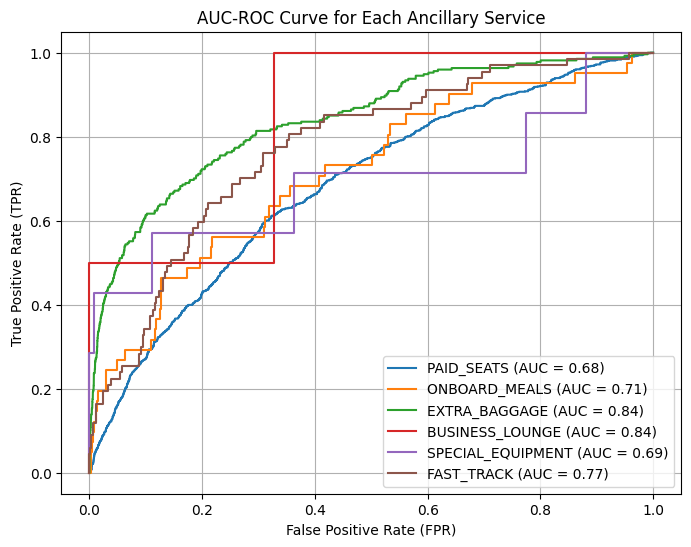

In [68]:
# Plot AUC-ROC for each ancillary service
plt.figure(figsize=(8, 6))

for i, ancillary in enumerate(ancillaries):
    y_true = y_test_tensor[:, i].numpy()
    y_prob = test_predicted_probs[:, i]
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{ancillary} (AUC = {auc_score:.2f})')
    
# Customize the plot
plt.title('AUC-ROC Curve for Each Ancillary Service')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [69]:
# for col in y_test_binary.columns:
#     print(y_test_binary[col].value_counts())

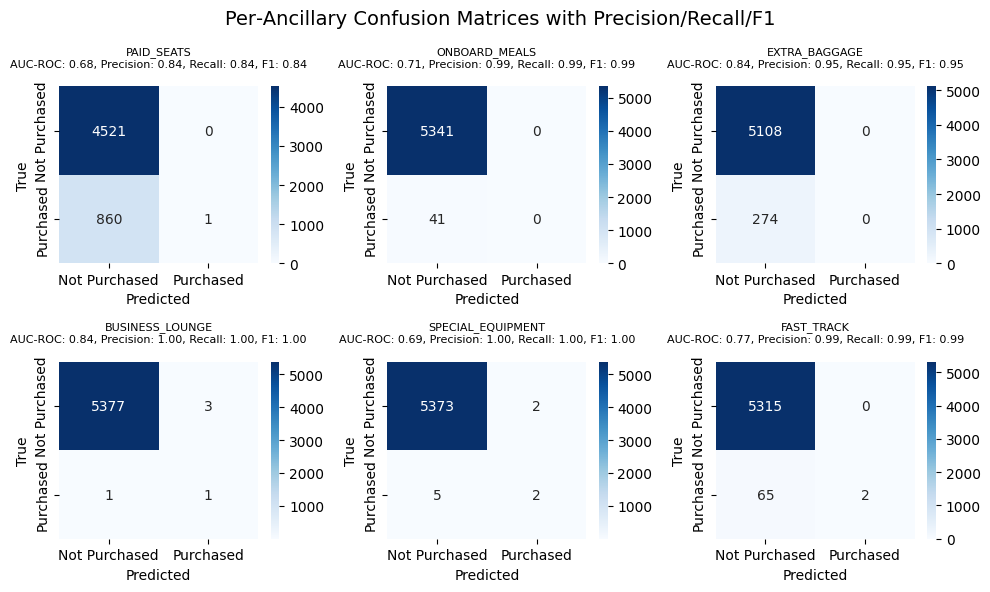

In [70]:
# Create a subplot grid for confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

# Plot confusion matrix for each ancillary service
for i, ancillary in enumerate(ancillaries):
    ytrue = y_test_tensor[:, i].numpy()
    yprob = test_predicted_probs[:, i]
    ypred = test_predicted[:, i]
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(ytrue, yprob)
    auc_score = auc(fpr, tpr)

    precision = precision_score(ytrue, ypred, average='micro')
    recall = recall_score(ytrue, ypred, average='micro')
    f1 = f1_score(ytrue, ypred, average='micro')
    title = (
        f"{ancillary}\n"
        f"AUC-ROC: {auc_score:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}\n"
    )

    cm = confusion_matrix(ytrue, ypred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Purchased', 'Purchased'], 
                yticklabels=['Not Purchased', 'Purchased'], ax=axes[i])
    axes[i].set_title(title, fontsize=8)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Adjust layout
fig.suptitle('Per‐Ancillary Confusion Matrices with Precision/Recall/F1', fontsize=14)
plt.tight_layout()
plt.show()

In [71]:
def compute_metrics(loader, model, threshold, ancillaries):
    model.eval()
    all_true, all_probs, all_preds = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            # xb = xb.to(device)
            logits = model(xb)
            probs  = torch.sigmoid(logits).cpu().numpy()
            preds  = (probs > threshold).astype(int)

            all_true.append(yb.numpy())
            all_probs.append(probs)
            all_preds.append(preds)

    y_true = np.vstack(all_true)
    y_prob = np.vstack(all_probs)
    y_pred = np.vstack(all_preds)

    rows = []
    for i, anc in enumerate(ancillaries):
        p   = precision_score(y_true[:,i], y_pred[:,i], average='micro')
        r   = recall_score(y_true[:,i], y_pred[:,i], average='micro')
        f1  = f1_score(y_true[:,i], y_pred[:,i], average='micro')
        auc = roc_auc_score(y_true[:,i], y_prob[:,i])
        rows.append({
            'ancillary': anc,
            'precision': p,
            'recall':    r,
            'f1_score':  f1,
            'roc_auc':   auc
        })
    return pd.DataFrame(rows)

In [72]:
# compute for each split
df_train = compute_metrics(train_loader, model, threshold, ancillaries)
df_train['dataset'] = 'train'

df_val   = compute_metrics(val_loader,   model, threshold, ancillaries)
df_val['dataset'] = 'val'

df_test  = compute_metrics(test_loader,  model, threshold, ancillaries)
df_test['dataset'] = 'test'

# combine
df_metrics = pd.concat([df_train, df_val, df_test], ignore_index=True)

# reorder columns
df_metrics = df_metrics[['dataset','ancillary','precision','recall','f1_score','roc_auc']]

# show
df_metrics

,dataset,ancillary,precision,recall,f1_score,roc_auc
0,train,PAID_SEATS,0.851523,0.851523,0.851523,0.683352
1,train,ONBOARD_MEALS,0.991001,0.991001,0.991001,0.842786
2,train,EXTRA_BAGGAGE,0.946128,0.946128,0.946128,0.854025
3,train,BUSINESS_LOUNGE,0.999960,0.999960,0.999960,0.999995
4,train,SPECIAL_EQUIPMENT,0.998288,0.998288,0.998288,0.997494
5,train,FAST_TRACK,0.987139,0.987139,0.987139,0.833526
6,val,PAID_SEATS,0.852100,0.852100,0.852100,0.664860
7,val,ONBOARD_MEALS,0.991453,0.991453,0.991453,0.788614
8,val,EXTRA_BAGGAGE,0.944444,0.944444,0.944444,0.838063
9,val,BUSINESS_LOUNGE,0.999071,0.999071,0.999071,0.708871


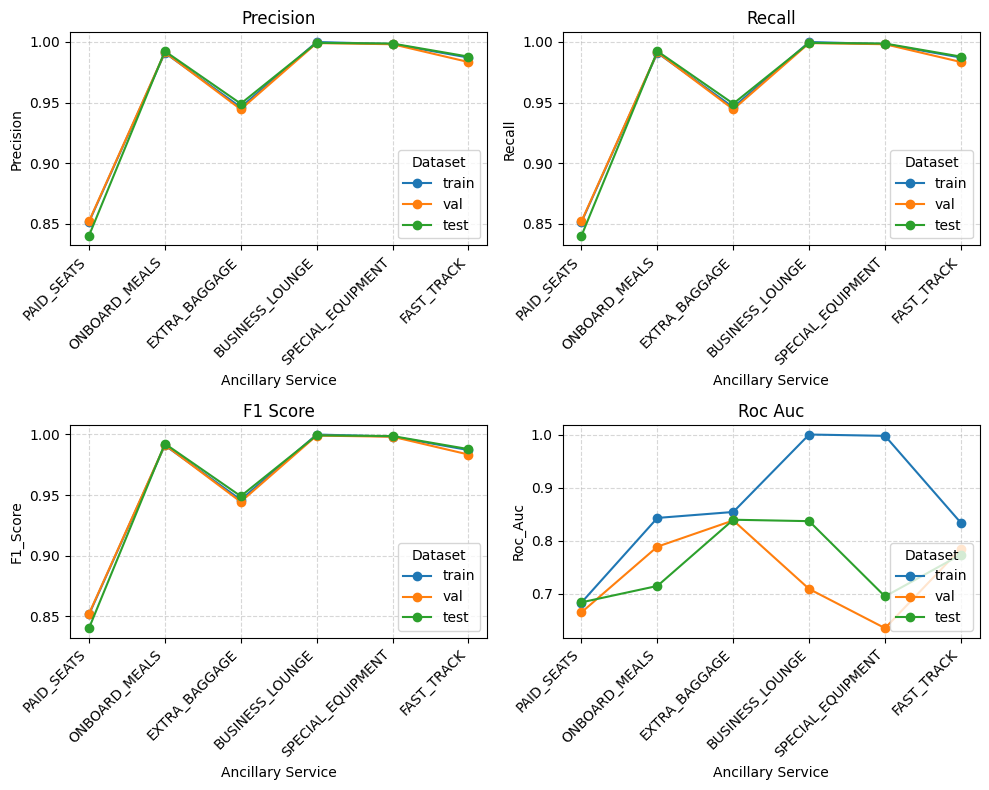

In [73]:
datasets = ['train','val','test']
ancillaries = df_metrics['ancillary'].unique()
metrics = ['precision','recall','f1_score','roc_auc']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    for ds in datasets:
        sub = df_metrics[df_metrics['dataset']==ds]
        # ensure ancillaries in same order
        values = [ sub.loc[sub['ancillary']==a, metric].values[0] for a in ancillaries ]
        ax.plot(ancillaries, values, marker='o', label=ds)
    ax.set_title(metric.replace('_',' ').title())
    ax.set_xlabel('Ancillary Service')
    ax.set_ylabel(metric.title())
    ax.set_xticks(range(len(ancillaries)))
    ax.set_xticklabels(ancillaries, rotation=45, ha='right')
    ax.legend(title='Dataset', loc='lower right')
    ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

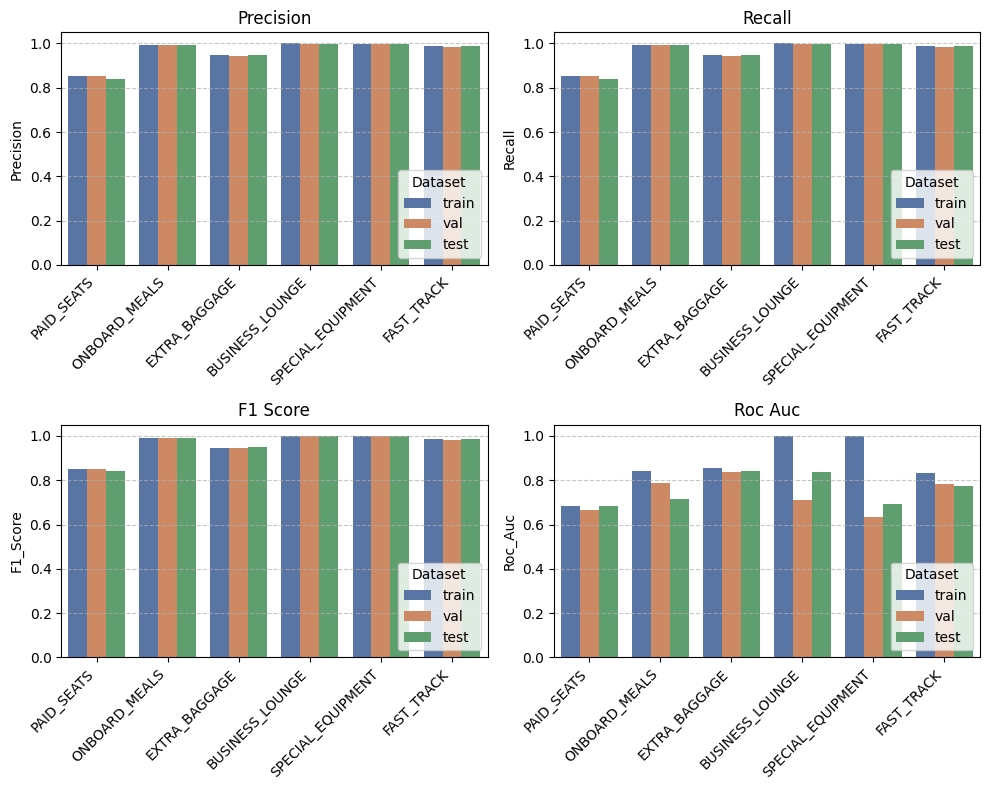

In [74]:
metrics = ['precision','recall','f1_score','roc_auc']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    sns.barplot(
        data=df_metrics,
        x='ancillary',
        y=metric,
        hue='dataset',
        ax=ax,
        palette='deep'
    )
    ax.set_title(metric.replace('_',' ').title())
    ax.set_xlabel('')
    ax.set_ylabel(metric.title())
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 1.05)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
    ax.legend(title='Dataset', loc='lower right')

plt.tight_layout()
plt.show()


In [75]:
# import optuna

# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

# def objective(trial):
#     # Suggest hyperparameters
#     lr          = trial.suggest_loguniform('lr', 1e-4, 1e-2)
#     hidden1     = trial.suggest_int('hidden1', 32, 256)
#     hidden2     = trial.suggest_int('hidden2', 16, hidden1)
#     dropout     = trial.suggest_float('dropout', 0.0, 0.5)
#     threshold   = trial.suggest_float('th', 0.2, 0.8)

#     model = NCFMLP(
#         num_features=num_features,
#         num_labels=len(ancillaries),
#         hidden1=hidden1,
#         hidden2=hidden2,
#         hidden3=hidden2//2,
#         hidden4=hidden2//4,
#         dropout=dropout).to(device)

#     # Pos‐weight for imbalance (reuse yours)
#     neg = (y_train_tensor==0).sum(0).float()
#     pos = (y_train_tensor==1).sum(0).float()
#     pos_weight = (neg/pos).clamp(min=1.0).to(device)
#     criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     # Train for a small number of epochs
#     for epoch in range(10):
#         model.train()
#         for xb, yb in train_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             optimizer.zero_grad()
#             logits = model(xb)
#             loss   = criterion(logits, yb)
#             loss.backward()
#             optimizer.step()

#     # Evaluate on validation set
#     model.eval()
#     all_preds, all_trues = [], []
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             xb = xb.to(device)
#             logits = model(xb)
#             probs  = torch.sigmoid(logits).cpu()
#             preds  = (probs > threshold).float().numpy()
#             all_preds.append(preds)
#             all_trues.append(yb.numpy())

#     y_pred = np.vstack(all_preds)
#     y_true = np.vstack(all_trues)

#     # Compute average F1 across labels
#     f1s = [f1_score(y_true[:,i], y_pred[:,i]) for i in range(y_true.shape[1])]
#     avg_f1 = float(np.mean(f1s))

#     # precision = precision_score(ytrue, ypred, average='micro')
#     # recall = recall_score(ytrue, ypred, average='micro')

#     # Report to Optuna
#     trial.report(avg_f1, epoch)
#     return avg_f1

# # 3) Run the study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=30, timeout=600)

# # 4) Display best hyperparameters
# print("Best trial:")
# trial = study.best_trial
# print(f"  Avg F1: {trial.value:.4f}")
# for key, val in trial.params.items():
#     print(f"  {key}: {val}")